**Importing the Required Libraries**

In [13]:
import os
import shutil
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers,models
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report

**Reading Data for Black Pigweed and Cotton classes**

In [14]:
img = []

## Pigweed Data
path_1 = glob.glob('/kaggle/input/cottonweedid15/CottonWeedID15/Purslane/*.jpg')
for image in path_1:
    n = cv2.imread(image)
    n = cv2.resize(n,(224,224))
    img.append(n)

array1 = np.asarray(img)/255
print(array1.shape)


## Cotton Dataset
img = []
path_2 = glob.glob('/kaggle/input/cottonweeds/Weeds dataset Uploaded/Weeds dataset Uploaded/Cotton/*.jpg')
count = 0
for image in path_2:
    count = count + 1
    if count <= 57:
        n = cv2.imread(image)
        n = cv2.resize(n,(224,224))
        img.append(n)
    else:
        break

array2 = np.asarray(img)/255
print(array2.shape)



(57, 224, 224, 3)
(57, 224, 224, 3)


**Splitting data into train, test and validation**

In [15]:
## Note zero label is for Weed and one for Cotton

## Concatenating both classes data into one
X = np.concatenate((array1,array2))
## Assigning labels to data
Y = np.concatenate((np.zeros(len(array1)),np.ones(len(array2))))

In [16]:
len(X), len(Y)

(114, 114)

In [17]:
## Dividing data into training and testing data
Xtr1,Xts,Ytr1,Yts = train_test_split(X,Y,test_size=0.15,shuffle=True)

In [18]:
print("Testing length",len(Xts),len(Yts))

Testing length 18 18


In [19]:
## Further dividing training data into training and Validation data
Xtr,Xv,Ytr,Yv = train_test_split(Xtr1,Ytr1,test_size=0.2,shuffle=True)

In [20]:
print("Training length",len(Xtr),len(Ytr))
print("Validation length",len(Xv),len(Yv))

Training length 76 76
Validation length 20 20


In [21]:
print("Training length",len(Xtr),len(Ytr))
print("Testing length",len(Xts),len(Yts))
print("Validation length",len(Xv),len(Yv))

Training length 76 76
Testing length 18 18
Validation length 20 20


**Defining and Training Transfer Learning Model Function**

In [22]:
### Uploading weights locally
local_weights_file = '/kaggle/input/mobilenet_v2_weights/tensorflow2/mobilenet_v2_weights_tf/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(include_top=False, pooling='avg', weights=local_weights_file, input_shape=(224,224,3))

# Create a Sequential model and add the base model as a layer
model = Sequential()
model.add(base_model)
model.add(Dense(1, activation='sigmoid'))

# Freeze the layers of the base model
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(Xtr, Ytr, epochs=4, validation_data=(Xv, Yv))

Epoch 1/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6793 - loss: 0.5960 - val_accuracy: 0.8500 - val_loss: 0.4468
Epoch 2/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 735ms/step - accuracy: 0.8546 - loss: 0.4595 - val_accuracy: 0.9500 - val_loss: 0.3356
Epoch 3/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step - accuracy: 0.8888 - loss: 0.3806 - val_accuracy: 0.9500 - val_loss: 0.2651
Epoch 4/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 884ms/step - accuracy: 0.9346 - loss: 0.2898 - val_accuracy: 1.0000 - val_loss: 0.2025


**Checking Model Performance On the Test Set**

In [25]:
# Predict probabilities
yhat_probs = model.predict(Xts, verbose=0)

In [26]:
# Convert probabilities to class labels
yhat_classes = (yhat_probs > 0.5).astype("int32")


In [27]:
# Reduce to 1D arrays
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [28]:
# Calculate metrics
accuracy = accuracy_score(Yts, yhat_classes)
precision = precision_score(Yts, yhat_classes)
recall = recall_score(Yts, yhat_classes)
f1 = f1_score(Yts, yhat_classes)
auc = roc_auc_score(Yts, yhat_probs)

In [29]:
# Print metrics
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)
print('ROC AUC: %f' % auc)

Accuracy: 0.888889
Precision: 0.888889
Recall: 0.888889
F1 score: 0.888889
ROC AUC: 0.962963


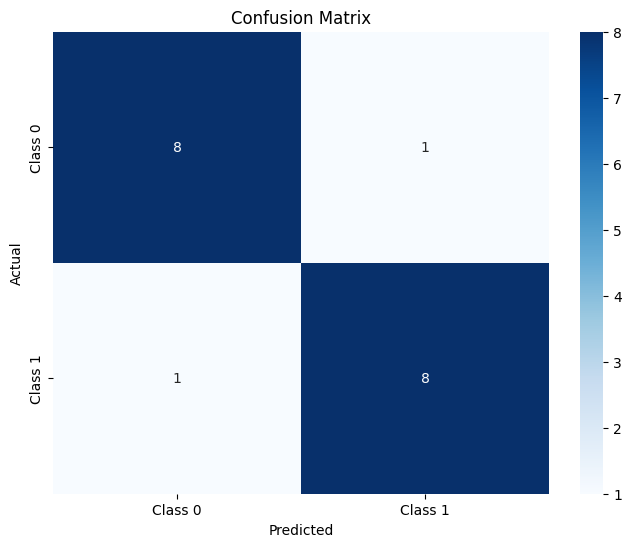

In [30]:
# Compute confusion matrix
cm = confusion_matrix(Yts, yhat_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Predict probabilities
yhat_probs = model.predict(Xts, verbose=0)

# Convert probabilities to class labels
yhat_classes = (yhat_probs > 0.5).astype("int32")

# Reduce to 1D arrays
yhat_classes = yhat_classes[:, 0]

# Calculate and print the classification report
report = classification_report(Yts, yhat_classes, target_names=['Weed', 'Cotton'])
print(report)

              precision    recall  f1-score   support

        Weed       0.89      0.89      0.89         9
      Cotton       0.89      0.89      0.89         9

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18

